In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import get_raw_subject_data

In [2]:
# def reshape_epochs(epochs, n_epochs_to_include):
#     """
#     Truncate the Epochs to a defined number and merge their time samples.
    
#     Parameters:
#         epochs (MNE Epochs): The epochs object containing the data.
#         n_epochs_to_include (int): The maximum number of epochs to consider.
        
#     Returns:
#         ndarray: A 2D array where each row represents a time point (merged from epochs)
#                  and each column corresponds to a channel.
#     """
#     # Retrieve and limit the epoch data
    
#     """Limit epochs to min bound, reshape data to channels x merged_epochs"""
#     epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
#     # epoch_data = epoch.get_data()
#     n_epoch, n_channels, n_epoch_size = epoch_data.shape
#     epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size)
#     return epoch_data_reshaped.T

In [3]:
def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Truncate the epochs to a given number, reshape their time samples,
    and also return an index array that labels each time sample with the
    original epoch index.
    """
    # Get epoch data: shape (n_epochs, n_channels, n_epoch_size)
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    # Reshape to (n_epochs*n_epoch_size, n_channels)
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size).T
    # Create an index array indicating the original epoch number for each sample
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

In [4]:
# epochs = get_raw_subject_data(subject=3)

# # Divide each activity and find the minimum number of samples
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# # Reshape all activities
# control_reshaped = reshape_epochs(control, min_bound)
# left_reshaped = reshape_epochs(left, min_bound)
# right_reshaped = reshape_epochs(right, min_bound)
# X = np.concatenate([control_reshaped, left_reshaped, right_reshaped], axis=0)

# l = control_reshaped.shape[0]
# y = np.concatenate([np.full(l, 1), np.full(l, 2), np.full(l, 3)])

# # Standardize data (should not be necessary for ICA, but good practice)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica = ica.fit_transform(X_scaled)

# # # Plot the raw epochs time series with epoch boundaries
# # plt.figure(figsize=(12, 6))
# # plt.plot(X, color='gray')
# # plt.axvline(x=l, color='black', linestyle='--', label='Control → Tapping Left')
# # plt.axvline(x=2*l, color='black', linestyle='--', label='Tapping Left → Tapping Right')
# # plt.xlabel('Time (samples)')
# # plt.ylabel('Amplitude')
# # plt.title('Time Series of Concatenated Epochs')
# # plt.legend()
# # plt.tight_layout()
# # plt.show()

In [5]:
# epochs = get_raw_subject_data(subject=3)

# # Di# Divide each activity and find the minimum number of epochs available
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# # Reshape all activities and get original epoch indices per sample
# control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
# left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
# right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# # Concatenate data and corresponding indices/lables
# X = np.concatenate([control_data, left_data, right_data], axis=0)
# orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
# print(left_idx)
# print(right_idx)
# print(ctrl_idx)
# print(orig_indices)
# y = np.concatenate([np.full(control_data.shape[0], 1),
#                     np.full(left_data.shape[0], 2),
#                     np.full(right_data.shape[0], 3)])

# # Standardize and run ICA as before
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica = ica.fit_transform(X_scaled)

# # Reconstruct the original order by sorting on orig_indices
# perm = np.argsort(orig_indices)
# X_ica_ordered = X_ica[perm, :]
# y_ordered = y[perm]

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...
Boundaries: [0, 4082, 8164, 12246]


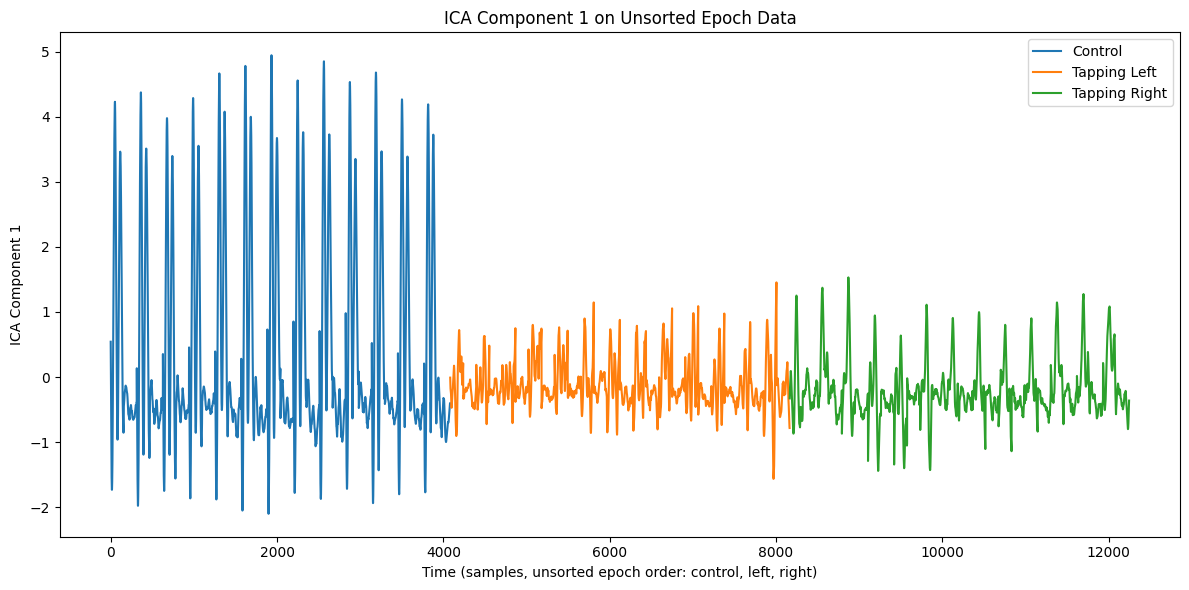

In [6]:
# --- Get raw epochs and reshape them with indices (as before)
epochs = get_raw_subject_data(subject=3)

control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# Concatenate in the original order: control, tapping left, tapping right
X = np.concatenate([control_data, left_data, right_data], axis=0)
# Here the class labels come in order naturally:
y = np.concatenate([np.full(control_data.shape[0], 1),
                    np.full(left_data.shape[0], 2),
                    np.full(right_data.shape[0], 3)])

# --- Pass the data into ICA WITHOUT any reordering --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica_unsorted = ica.fit_transform(X_scaled)
y_unsorted = y  # the order is as originally concatenated

# --- Now define the boundaries corresponding to each condition ----------
n_control = control_data.shape[0]
n_left = left_data.shape[0]
n_right = right_data.shape[0]
# Boundaries along the time axis (each epoch chunk is contiguous)
boundaries = [0, n_control, n_control + n_left, n_control + n_left + n_right]
print("Boundaries:", boundaries)

# --- Plot the ICA time series for Component 1 using the unsorted data ---
plt.figure(figsize=(12, 6))
colors = {1: "C0", 2: "C1", 3: "C2"}

# Plot control block
plt.plot(np.arange(boundaries[0], boundaries[1]),
         X_ica_unsorted[boundaries[0]:boundaries[1], 0],
         color=colors[1], label="Control")

# Plot tapping left block
plt.plot(np.arange(boundaries[1], boundaries[2]),
         X_ica_unsorted[boundaries[1]:boundaries[2], 0],
         color=colors[2], label="Tapping Left")

# Plot tapping right block
plt.plot(np.arange(boundaries[2], boundaries[3]),
         X_ica_unsorted[boundaries[2]:boundaries[3], 0],
         color=colors[3], label="Tapping Right")

plt.xlabel("Time (samples, unsorted epoch order: control, left, right)")
plt.ylabel("ICA Component 1")
plt.title("ICA Component 1 on Unsorted Epoch Data")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import FastICA
# from sklearn.preprocessing import StandardScaler
# from preprocessing_mne import get_raw_subject_data

# # --- Get epochs and reshape them (as before) ---
# epochs = get_raw_subject_data(subject=3)
# control = epochs['Control']
# left = epochs['Tapping_Left']
# right = epochs['Tapping_Right']
# min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

# control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
# left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
# right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# # Create class labels for each block
# y_control = np.full(control_data.shape[0], 1)
# y_left    = np.full(left_data.shape[0], 2)
# y_right   = np.full(right_data.shape[0], 3)

# # Concatenate all data and labels in the original order
# X = np.concatenate([control_data, left_data, right_data], axis=0)
# y = np.concatenate([y_control, y_left, y_right])

# # --- Randomize the order of the concatenated data ---
# perm = np.random.permutation(X.shape[0])
# X_random = X[perm, :]
# y_random = y[perm]

# # --- Standardize and run ICA ---
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_random)
# ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
# X_ica_random = ica.fit_transform(X_scaled)

# # --- Plotting ICA Component 1 with samples color-coded by class ---
# plt.figure(figsize=(12, 6))
# colors = {1: "C0", 2: "C1", 3: "C2"}

# for lab in np.unique(y_random):
#     mask = y_random == lab
#     plt.plot(np.where(mask)[0], X_ica_random[mask, 0], color=colors[lab], label=f"Class {lab}")

# plt.xlabel("Samples (randomized order)")
# plt.ylabel("ICA Component 1")
# plt.title("ICA Component 1 on Randomized Epoch Data")
# plt.legend()
# plt.tight_layout()
# plt.show()

Reading 0 ... 23120  =      0.000 ...  2959.360 secs...


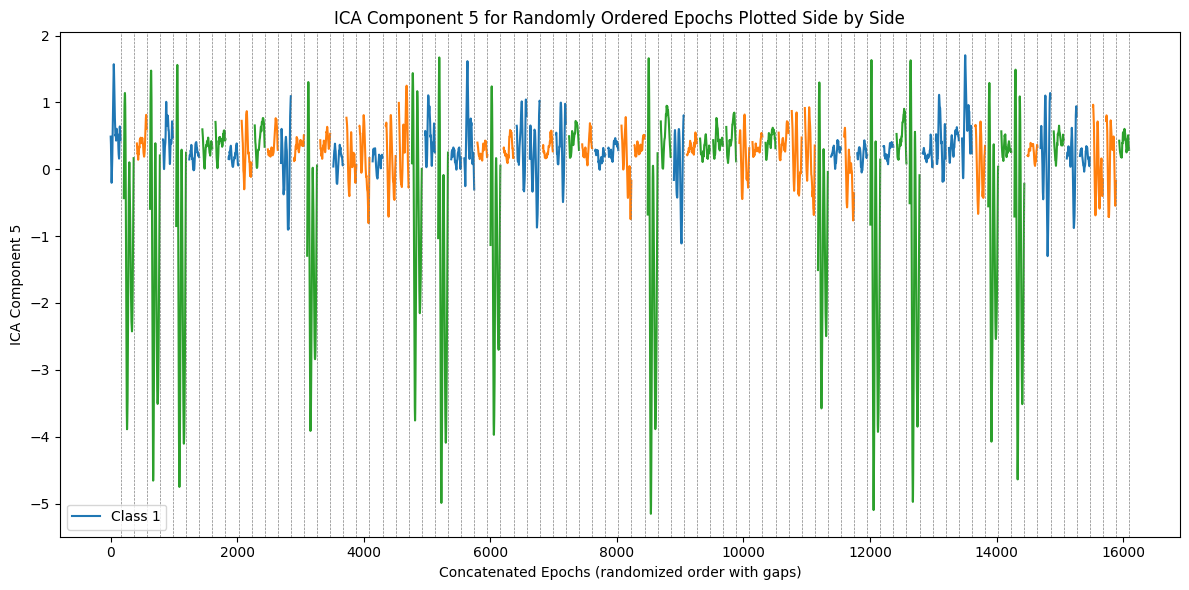

In [8]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from preprocessing_mne import get_raw_subject_data

# --- Get epochs and reshape them (as before) ---
epochs = get_raw_subject_data(subject=3)
control = epochs['Control']
left = epochs['Tapping_Left']
right = epochs['Tapping_Right']
min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])

control_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
right_data, right_idx = reshape_epochs_with_indices(right, min_bound)

# Concatenate data, epoch indices, and labels
X = np.concatenate([control_data, left_data, right_data], axis=0)
orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
y = np.concatenate([np.full(control_data.shape[0], 1),
                    np.full(left_data.shape[0], 2),
                    np.full(right_data.shape[0], 3)])

# --- Standardize and run ICA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ica = FastICA(n_components=5, max_iter=1000, tol=0.0001, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# --- Reorder epochs randomly and plot them side by side ---
# Each unique value in orig_indices corresponds to one epoch
unique_epochs = np.unique(orig_indices)
# Randomize the order of these epochs
rand_epochs = np.random.permutation(unique_epochs)

gap = 50      # gap (in samples) between each epoch's plot
x_offset = 0  # current horizontal offset
plt.figure(figsize=(12, 6))
colors = {1: "C0", 2: "C1", 3: "C2"}

for epoch_id in rand_epochs:
    # Select all samples belonging to the current epoch
    ep_mask = orig_indices == epoch_id
    # Extract ICA Component 1 for this epoch
    ep_data = X_ica[ep_mask, 4]
    # All samples in the same epoch have the same class label
    label = y[ep_mask][0]
    # Create an x-axis for this epoch (shifted by current offset)
    x_range = np.arange(len(ep_data)) + x_offset
    plt.plot(x_range, ep_data, color=colors[label],
             label=f"Class {label}" if x_offset == 0 else "")
    # Draw a separator line at the end of the epoch segment
    plt.axvline(x=x_offset + len(ep_data), color='gray', linestyle='--', linewidth=0.5)
    # Update offset: current epoch length plus a fixed gap
    x_offset += len(ep_data) + gap

plt.xlabel("Concatenated Epochs (randomized order with gaps)")
plt.ylabel("ICA Component 5")
plt.title("ICA Component 5 for Randomly Ordered Epochs Plotted Side by Side")
plt.legend()
plt.tight_layout()
plt.show()

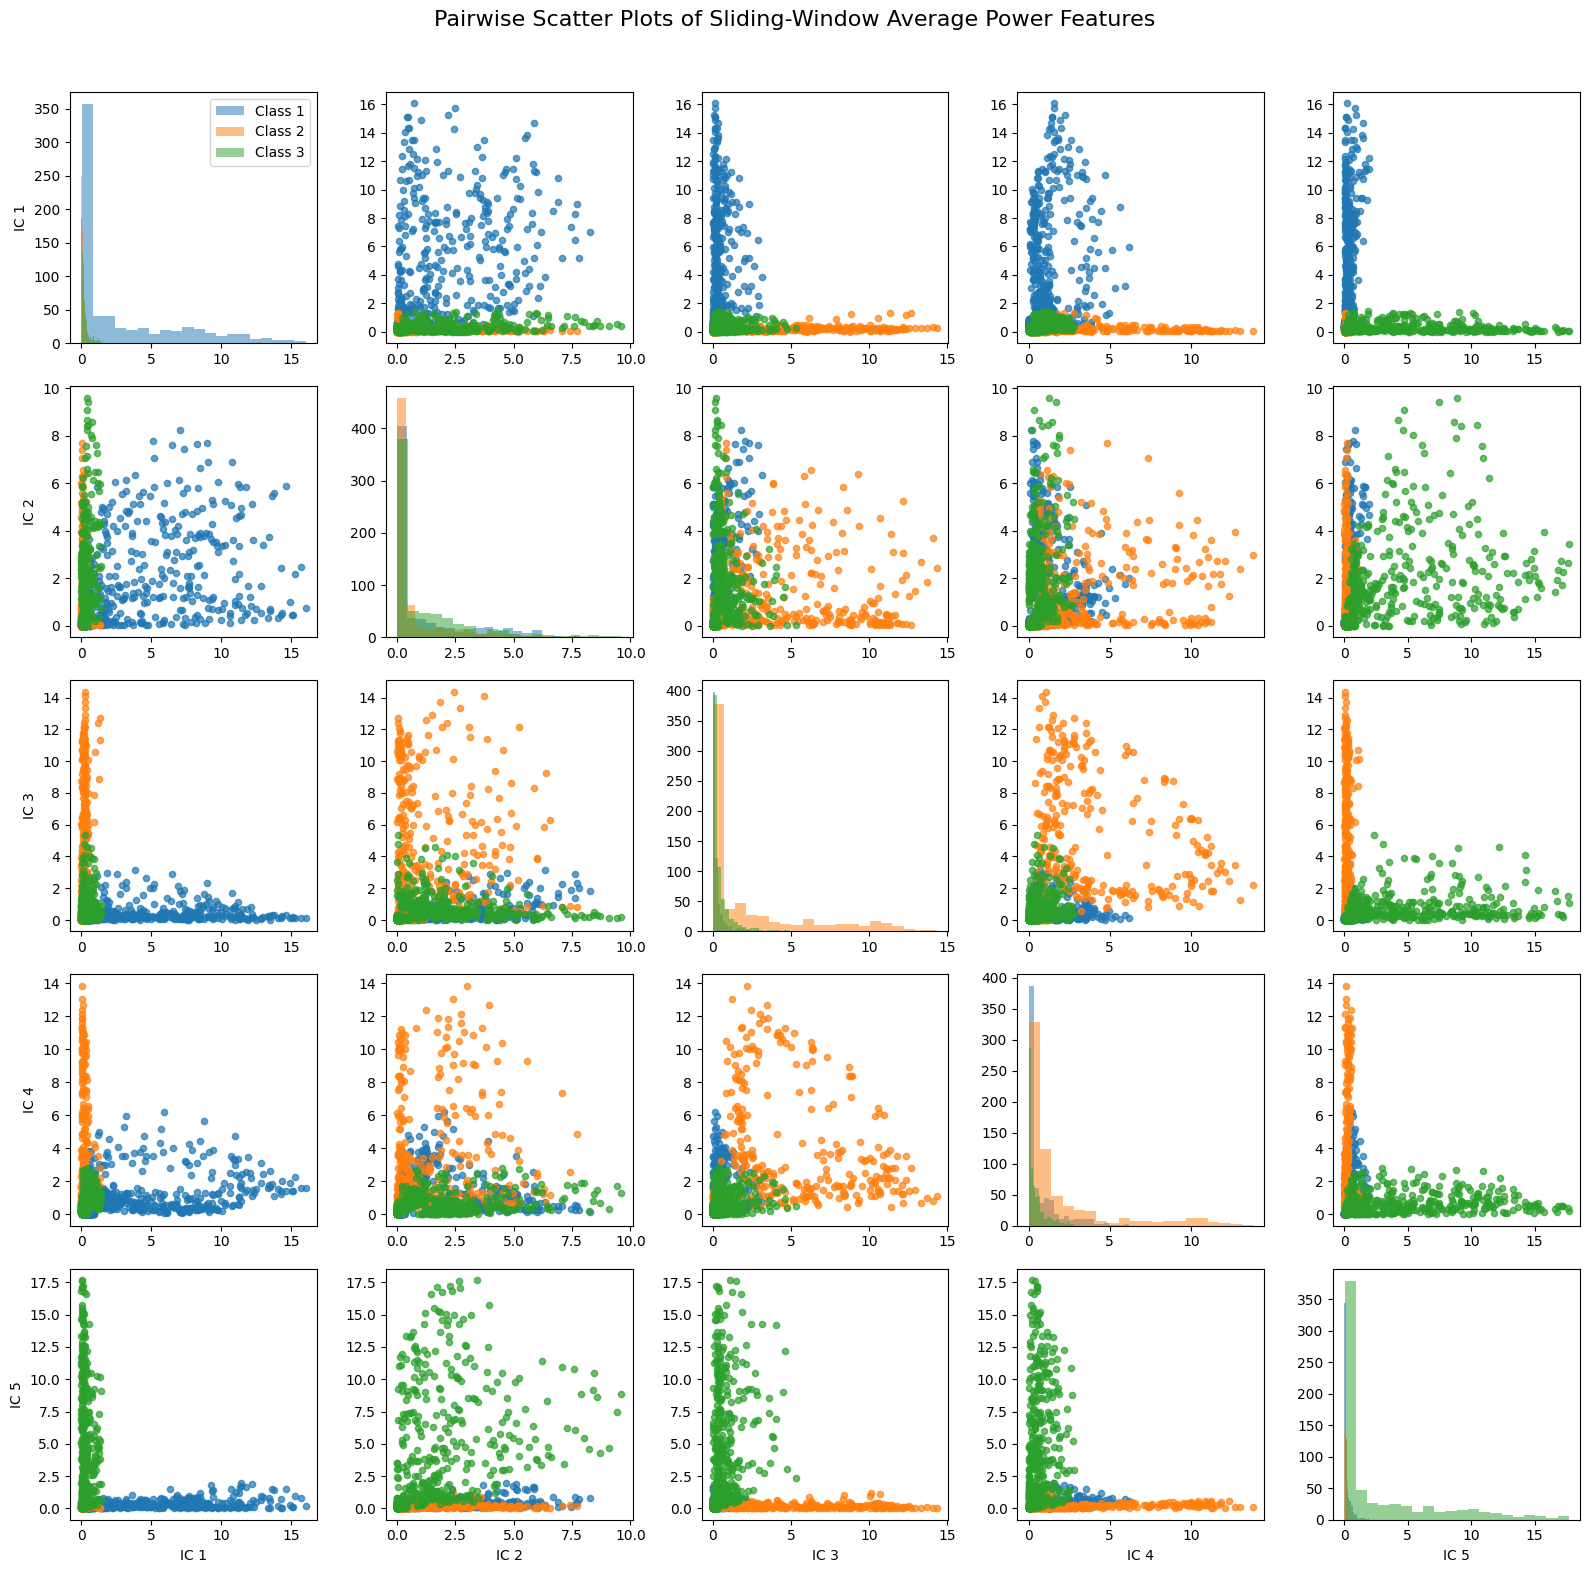

In [9]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters for sliding window ---
window_size = 30  # window length in samples
step_size = 5     # step size

# Lists to store feature vectors and corresponding labels
features_list = []
labels_list = []

# Iterate over each epoch using orig_indices
unique_epochs = np.unique(orig_indices)
for epoch_id in unique_epochs:
    # Get all samples for this epoch
    epoch_mask = orig_indices == epoch_id
    epoch_data = X_ica[epoch_mask, :]  # shape: (n_epoch_samples, 5)
    # All samples in an epoch share the same class label
    epoch_label = y[epoch_mask][0]
    n_samples_epoch = epoch_data.shape[0]
    
    # Slide a window over this epoch without crossing its boundary
    for start in range(0, n_samples_epoch - window_size + 1, step_size):
        end = start + window_size
        window = epoch_data[start:end, :]
        # Compute average power (mean square) for each component
        avg_power = np.mean(window**2, axis=0)  # (5,)
        features_list.append(avg_power)
        labels_list.append(epoch_label)

# Final features: each row is a 5-D feature vector for one window
features = np.array(features_list)   # shape: (n_windows_total, 5)
labels = np.array(labels_list)

# --- Plot pairwise scatter plots of the 5-D power feature vectors ---
n_components = features.shape[1]
colors = {1: "C0", 2: "C1", 3: "C2"}

fig, axes = plt.subplots(n_components, n_components, figsize=(16, 16))
fig.suptitle("Pairwise Scatter Plots of Sliding-Window Average Power Features", fontsize=16)

for i in range(n_components):
    for j in range(n_components):
        ax = axes[i, j]
        if i == j:
            # Plot a histogram on the diagonal
            for cl in sorted(np.unique(labels)):
                cl_mask = labels == cl
                ax.hist(features[cl_mask, i], bins=20, alpha=0.5, color=colors[cl],
                        label=f"Class {cl}")
            if i == 0:
                ax.legend()
        else:
            # Scatter plot: x-axis: component j, y-axis: component i
            for cl in sorted(np.unique(labels)):
                cl_mask = labels == cl
                ax.scatter(features[cl_mask, j], features[cl_mask, i],
                           color=colors[cl], alpha=0.7, s=20, label=f"Class {cl}" if (i==0 and j==n_components-1) else "")
        if i == n_components - 1:
            ax.set_xlabel(f"IC {j+1}")
        if j == 0:
            ax.set_ylabel(f"IC {i+1}")

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

Number of windows: 2028
Clusters: 2, Silhouette Score: 0.5373
Clusters: 3, Silhouette Score: 0.5994


c:\Users\oscar\anaconda3\envs\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\oscar\anaconda3\envs\venv\Lib\subprocess.py", line 1538, in _exec

Clusters: 4, Silhouette Score: 0.6526
Clusters: 5, Silhouette Score: 0.6724
Clusters: 6, Silhouette Score: 0.6049
Clusters: 7, Silhouette Score: 0.5946
Clusters: 8, Silhouette Score: 0.5874
Clusters: 9, Silhouette Score: 0.5709
Clusters: 10, Silhouette Score: 0.5947


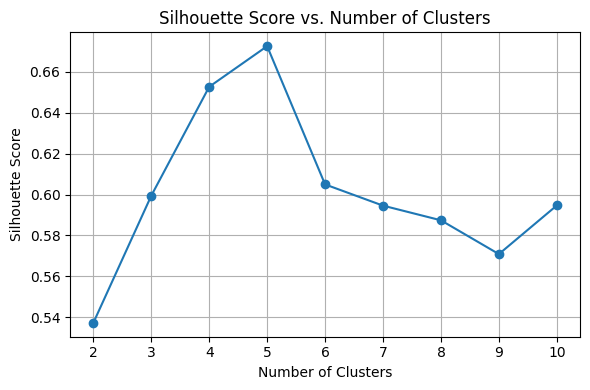

Optimal number of clusters based on silhouette score: 5


In [10]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test a range of cluster counts (e.g., from 2 to 10)
cluster_range = range(2, 11)
sil_scores = []

print(f'Number of windows: {features.shape[0]}')

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    score = silhouette_score(features, cluster_labels)
    sil_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(cluster_range), sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(list(cluster_range))
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = cluster_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters based on silhouette score: {best_k}")

Number of control windows: 676
Clusters: 2, Silhouette Score: 0.6624
Clusters: 3, Silhouette Score: 0.5924
Clusters: 4, Silhouette Score: 0.5748
Clusters: 5, Silhouette Score: 0.5851
Clusters: 6, Silhouette Score: 0.5925
Clusters: 7, Silhouette Score: 0.5847
Clusters: 8, Silhouette Score: 0.5834
Clusters: 9, Silhouette Score: 0.5793
Clusters: 10, Silhouette Score: 0.5929


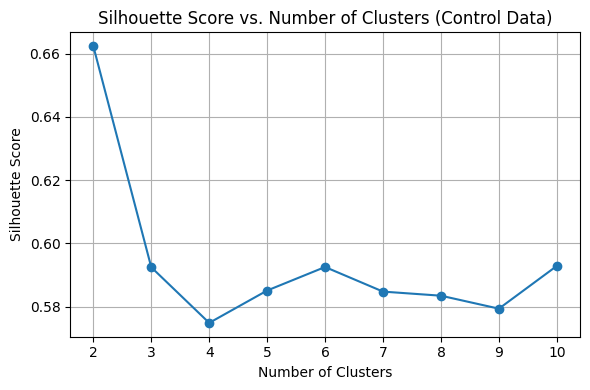

Optimal number of clusters for control data: 2


In [11]:
# New cell in ICA_stacked_epochs.ipynb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Using the previously computed sliding-window features (power_features)
# and the corresponding window_labels (where class 1 = Control):
control_mask = (labels == 1)
control_power_features = features[control_mask]

print("Number of control windows:", control_power_features.shape[0])

# Test a range of cluster counts (e.g., from 2 to 10) on control data
cluster_range = range(2, 11)
sil_scores_control = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels_control = kmeans.fit_predict(control_power_features)
    score = silhouette_score(control_power_features, cluster_labels_control)
    sil_scores_control.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(cluster_range), sil_scores_control, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (Control Data)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(list(cluster_range))
plt.grid(True)
plt.tight_layout()
plt.show()

best_k_control = cluster_range[np.argmax(sil_scores_control)]
print(f"Optimal number of clusters for control data: {best_k_control}")

## Getting more clusters when including tapping data

We define a control preiod before the tapping command is given. Then define a tapping period after. Pass this data into the ICA, run a sliding window average power computation (skipping the overlap between different epochs) and checking for clusters.

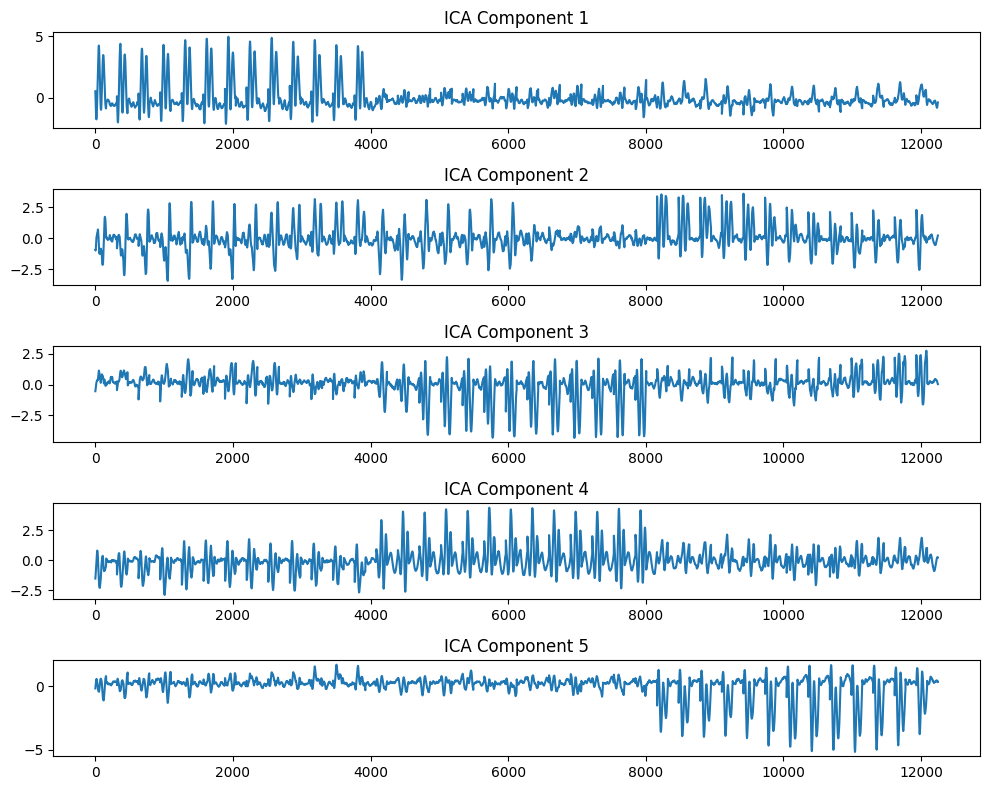

In [12]:
plt.figure(figsize=(10, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f'ICA Component {i + 1}')
plt.tight_layout()
plt.show()

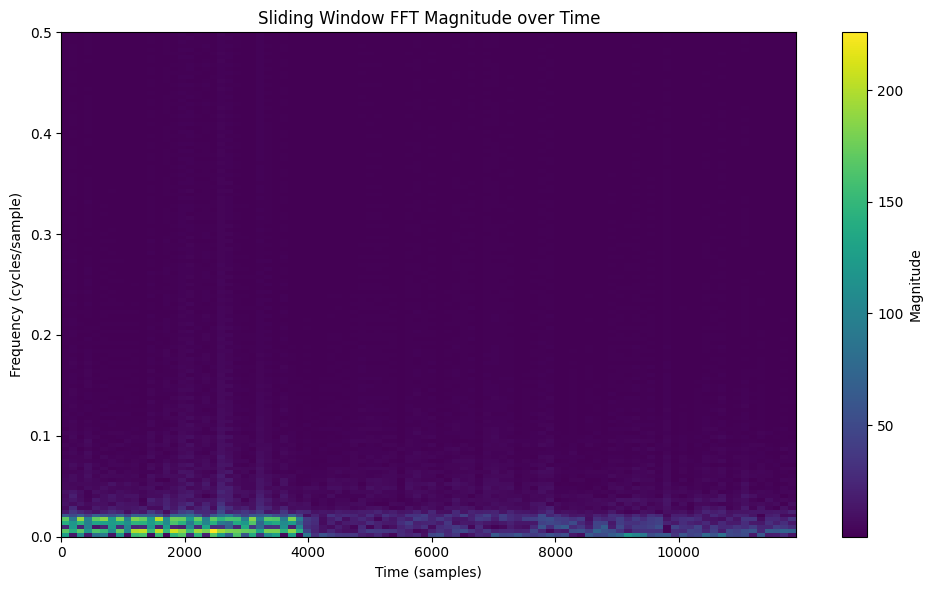

In [13]:
# Select the first channel from X as the signal for FFT analysis
signal = X_ica[:, 0]

# Define window and step sizes
win_size = 256      # window length (number of samples)
step_size = 128     # sliding step

# Calculate the number of windows
num_windows = (len(signal) - win_size) // step_size + 1

# Pre-allocate the spectrogram array (only non-negative frequencies are returned)
spectrogram = np.zeros((num_windows, win_size // 2 + 1))

# Compute FFT for each window and store the magnitude spectrum
for i in range(num_windows):
    start = i * step_size
    window_data = signal[start:start + win_size]
    fft_result = np.fft.rfft(window_data)
    spectrogram[i, :] = np.abs(fft_result)

# Frequency axis for FFT (in cycles per sample)
freqs = np.fft.rfftfreq(win_size, d=1)

# Time axis: here we use the starting index of each window as the time marker
times = np.arange(num_windows) * step_size

# Plot the spectrogram as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=(times[0], times[-1], freqs[0], freqs[-1]))
plt.xlabel('Time (samples)')
plt.ylabel('Frequency (cycles/sample)')
plt.title('Sliding Window FFT Magnitude over Time')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

Reading 0 ... 23006  =      0.000 ...  2944.768 secs...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


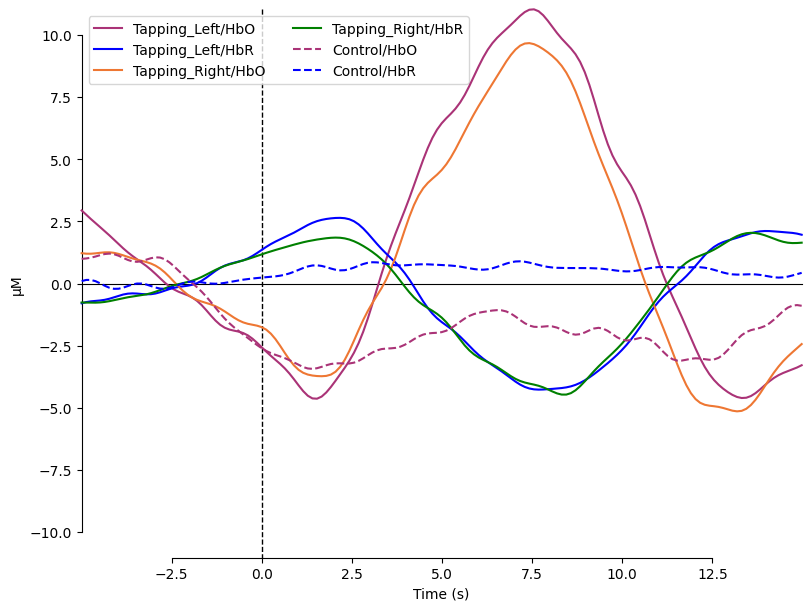

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


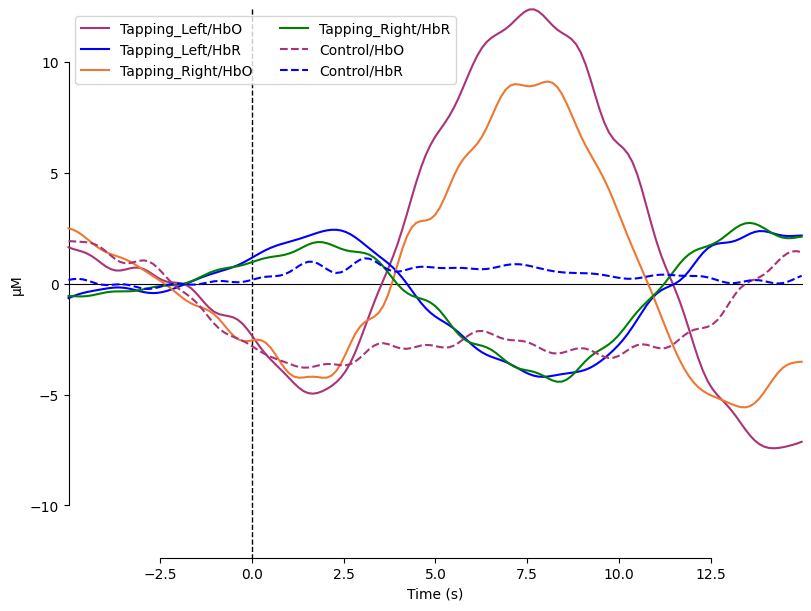

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


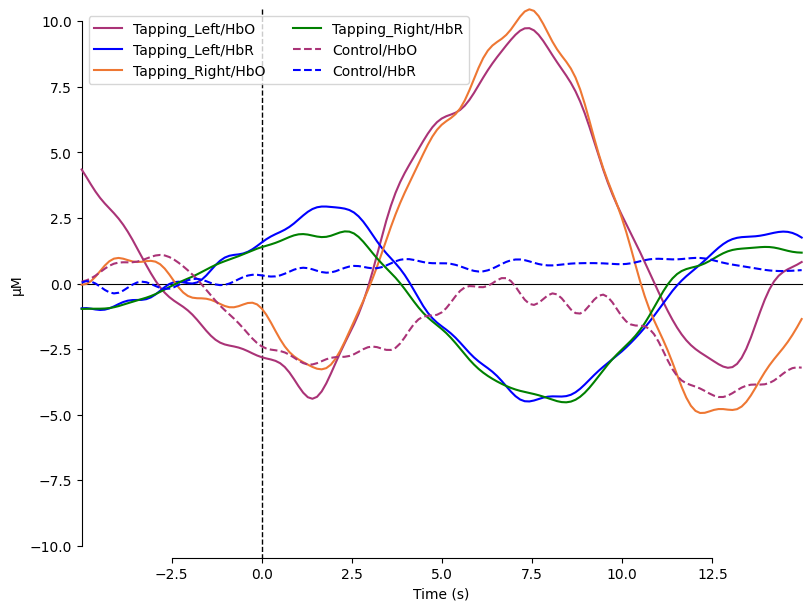

[[[ 4.76499119e-06  6.06154963e-06  7.25004962e-06 ...  1.83025182e-05
    1.69720940e-05  1.47852582e-05]
  [ 1.22095698e-06 -7.33347586e-07 -2.66998892e-06 ... -3.14039824e-06
   -2.44366078e-06 -1.24495444e-06]
  [ 1.17345031e-06 -1.15448487e-07 -5.09822010e-07 ...  8.68090864e-06
    7.10807558e-06  6.53810783e-06]
  ...
  [ 1.66812413e-06  1.93662142e-06  1.91307639e-06 ... -1.41402086e-06
   -1.71262071e-06 -2.07251857e-06]
  [-6.35444480e-07 -6.83741263e-07 -9.97795149e-07 ...  1.05150966e-05
    9.84575871e-06  8.72666362e-06]
  [ 1.08772790e-06  7.43616753e-07  4.00103477e-07 ... -3.58344347e-06
   -3.77388374e-06 -3.84683302e-06]]

 [[-3.25858082e-06 -4.61082640e-06 -4.87483445e-06 ... -5.67349409e-06
   -6.63110984e-06 -7.32599406e-06]
  [ 7.04765122e-06  8.03785795e-06  8.45092947e-06 ...  2.94051812e-06
    3.72372377e-06  4.44049439e-06]
  [ 2.25142307e-06  3.82512635e-07 -5.03774010e-07 ...  5.09059359e-06
    2.45774273e-06 -5.78218597e-07]
  ...
  [-4.11378305e-06 -4.3

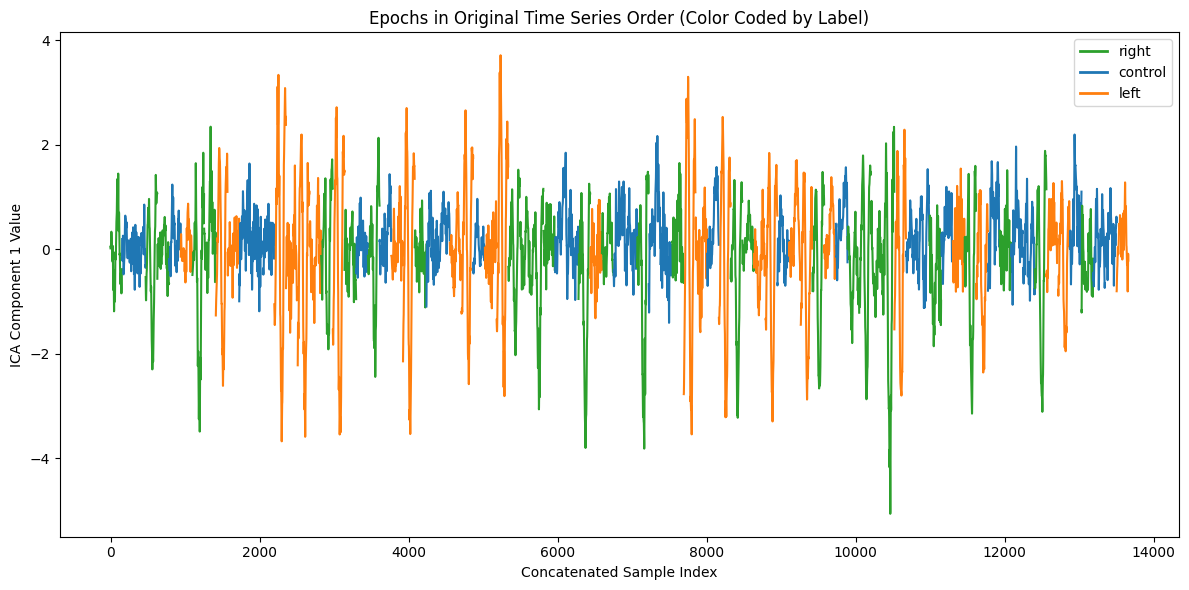

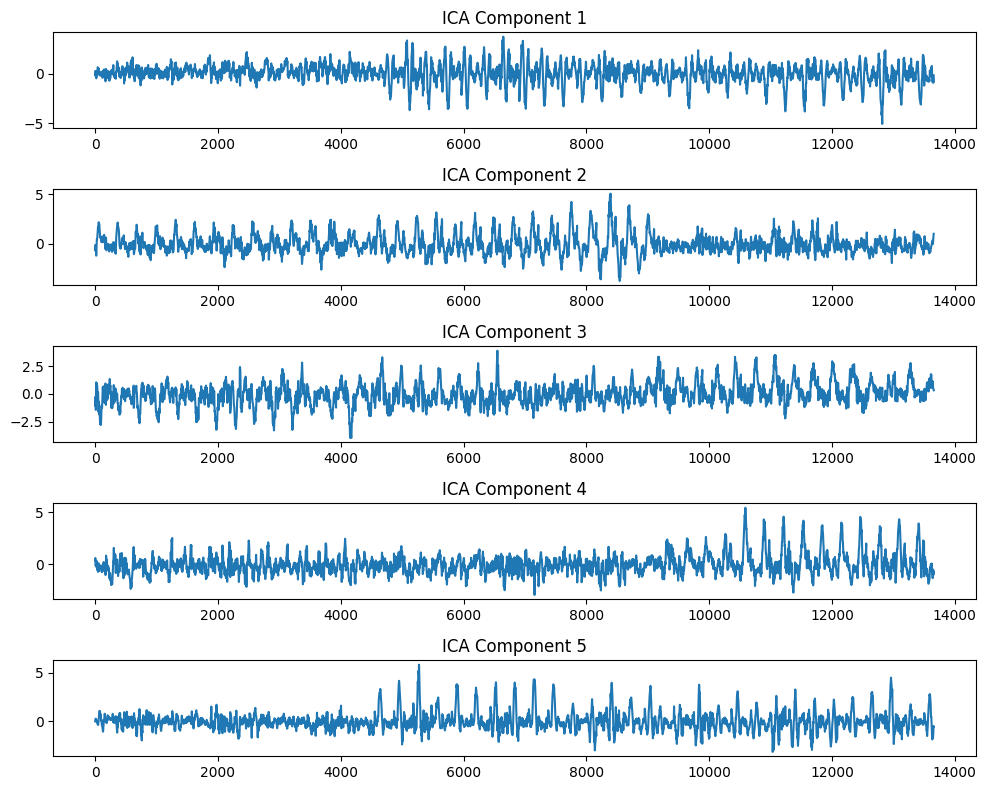

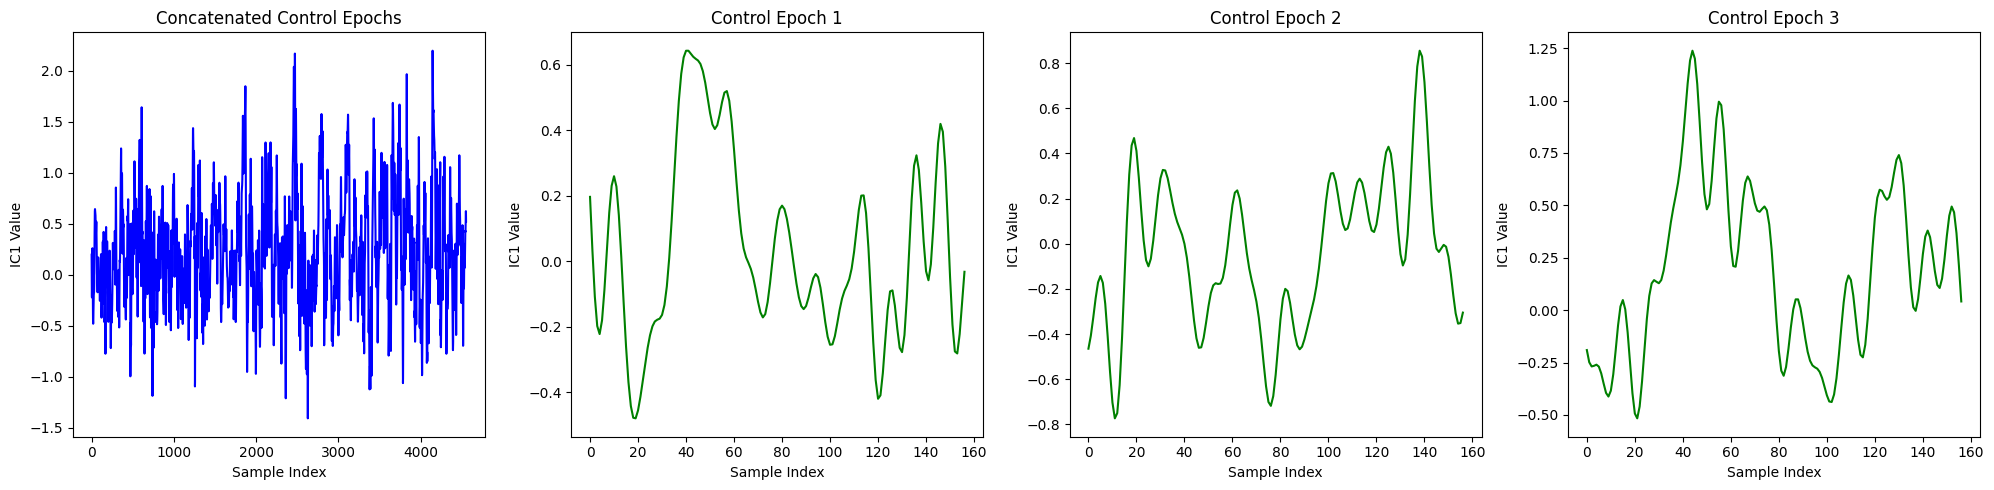

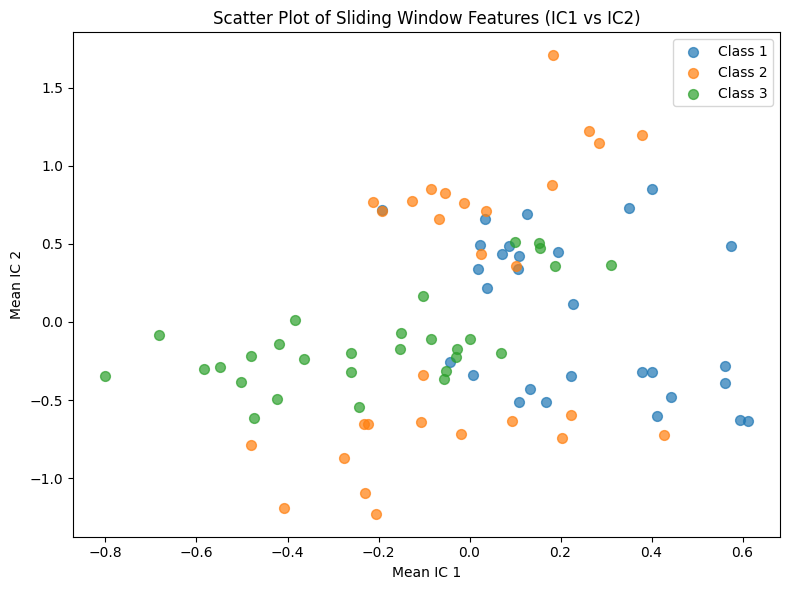

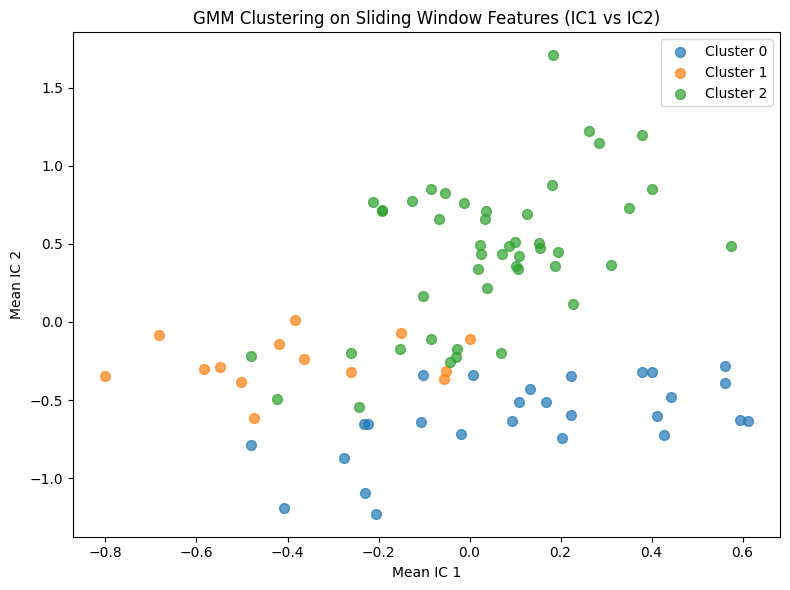

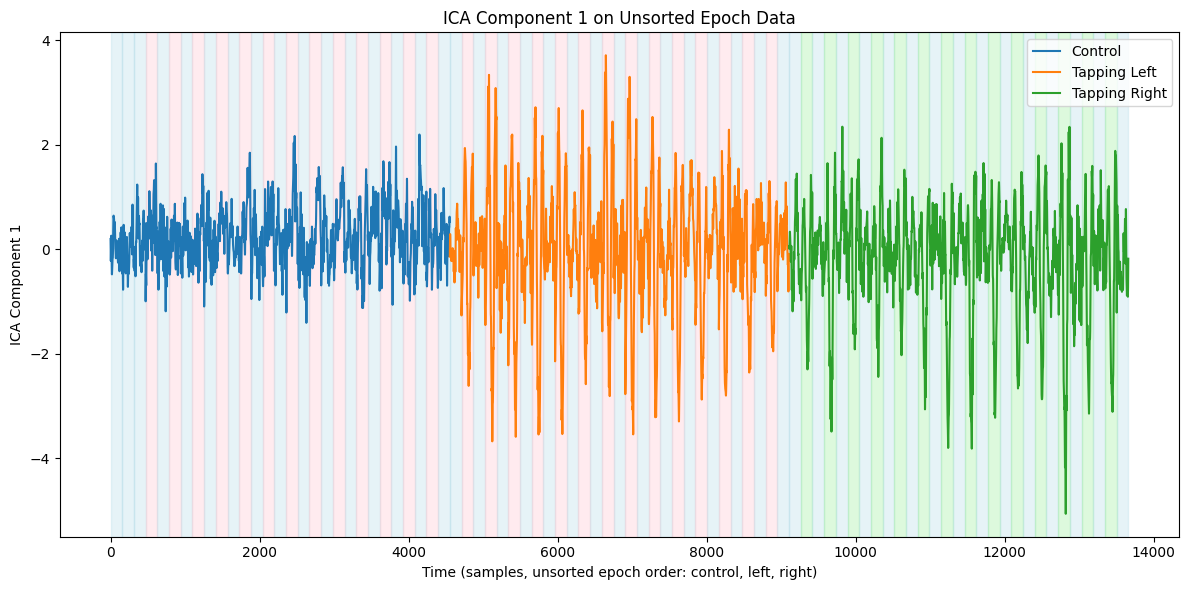

In [14]:
import os
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from preprocessing_mne import get_raw_subject_data, get_raw_control_subject_data
from ICA_plotting import *
from sklearn.metrics import silhouette_score
import random
import matplotlib.pyplot as plt
import mne

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Reshape epochs data to a 2D array and create an index array that indicates the original epoch for each sample.
    Using the minimum number of samples from the conditions for uniformity for concatenation.

    Parameters:
        epochs: MNE epochs object containing the data.
        n_epochs_to_include: Number of epochs to include (using the minimum sample count for uniformity).

    Returns:
        tuple: (reshaped data, array of original epoch indices)
    """
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    print(epoch_data)
    print(epoch_data.shape)
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    # random_epochs = random.sample(range(n_epoch), 5)
    # for i in random_epochs:
    #     print(f"Length of epoch {i}: {epoch_data[i].shape[1]}")
    epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size).T
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

def load_data(subject=3, control_only=True):
    """
    Load data from MNE, reshape epochs, and concatenate data from control, left, and right conditions.
    We assume that the clinical trials can split the data up into control and potential activation

    Parameters:
        subject: Subject ID to load data for.

    Returns:
        tuple: (X, orig_indices, y, control_data, left_data, right_data, numb_samples)
            - X: concatenated continuous data.
            - orig_indices: epoch indices for each sample.
            - y: labels for each sample.
            - control_data, left_data, right_data: individual condition data.
            - numb_samples: length of the first epoch sample (number of time points).
    """

    if not control_only:
        epochs = get_raw_subject_data(subject=subject, tmin=-5, tmax=15)
        # epochs["Control"].plot_image(
        #     combine="mean",
        #     vmin=-30,
        #     vmax=30,
        #     ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
        # )

        # Plotting HbO and HbR on the same figure using all even epochs to illustrate relation between the two signals
        # (HbR decreases shortly after HbO increases)

        color_dict = {
            "Tapping_Left/HbO": "#AA3377",
            "Tapping_Left/HbR": "b",
            "Tapping_Right/HbO": "#EE7733",
            "Tapping_Right/HbR": "g",
            "Control/HbO": "#AA3377",
            "Control/HbR": "b",
        }
        styles_dict = dict(Control=dict(linestyle="dashed"))

        # Avg
        evoked_dict = {
            "Tapping_Left/HbO": epochs["Tapping_Left"].average(picks="hbo"),
            "Tapping_Left/HbR": epochs["Tapping_Left"].average(picks="hbr"),
            "Tapping_Right/HbO": epochs["Tapping_Right"].average(picks="hbo"),
            "Tapping_Right/HbR": epochs["Tapping_Right"].average(picks="hbr"),
            "Control/HbO": epochs["Control"].average(picks="hbo"),
            "Control/HbR": epochs["Control"].average(picks="hbr"),
        }

        # Rename channels until the encoding of frequency in ch_name is fixed
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4])

        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        )


        # USING ALL EVEN EPOCHS
        evoked_dict = {
            "Tapping_Left/HbO": epochs["Tapping_Left"][::2].average(picks="hbo"),
            "Tapping_Left/HbR": epochs["Tapping_Left"][::2].average(picks="hbr"),
            "Tapping_Right/HbO": epochs["Tapping_Right"][::2].average(picks="hbo"),
            "Tapping_Right/HbR": epochs["Tapping_Right"][::2].average(picks="hbr"),
            "Control/HbO": epochs["Control"][::2].average(picks="hbo"),
            "Control/HbR": epochs["Control"][::2].average(picks="hbr"),
        }

        # Rename channels until the encoding of frequency in ch_name is fixed
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4])

        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        )

        # USING ALL ODD EPOCHS
        evoked_dict = {
            "Tapping_Left/HbO": epochs["Tapping_Left"][1::2].average(picks="hbo"),
            "Tapping_Left/HbR": epochs["Tapping_Left"][1::2].average(picks="hbr"),
            "Tapping_Right/HbO": epochs["Tapping_Right"][1::2].average(picks="hbo"),
            "Tapping_Right/HbR": epochs["Tapping_Right"][1::2].average(picks="hbr"),
            "Control/HbO": epochs["Control"][1::2].average(picks="hbo"),
            "Control/HbR": epochs["Control"][1::2].average(picks="hbr"),
        }

        # Rename channels until the encoding of frequency in ch_name is fixed
        for condition in evoked_dict:
            evoked_dict[condition].rename_channels(lambda x: x[:-4])

        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        )

        control = epochs['Control']
        left = epochs['Tapping_Left']
        right = epochs['Tapping_Right']
        
        min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])
        
        control_only_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
        left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
        right_data, right_idx = reshape_epochs_with_indices(right, min_bound)
        
        # Concatenating data. Doesn't impact ICA
        X = np.concatenate([control_only_data, left_data, right_data], axis=0)
        orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
        y = np.concatenate([np.full(control_only_data.shape[0], 1),
                            np.full(left_data.shape[0], 2),
                            np.full(right_data.shape[0], 3)])
        # Get number of samples from the first epoch of the control condition.
        numb_samples = control.get_data()[0].shape[1]
        return X, orig_indices, y, control_only_data, left_data, right_data, numb_samples
    else:
        control = get_raw_control_subject_data(subject=subject)
        control_only_data, ctrl_idx = reshape_epochs_with_indices(control, control.selection.shape[0])
        y = np.full(control_only_data.shape[0], 1)  # All control data labeled as 1
        # Get number of samples from the first epoch of the control condition.
        numb_samples = control.get_data()[0].shape[1]
        return control_only_data, ctrl_idx, y, control_only_data, None, None, numb_samples


def run_ica(X, n_components=5, standardized=False):
    """
    Run Independent Component Analysis (ICA) to unmix the data.

    Parameters:
        X: Input data array.
        n_components: Number of independent components to retrieve.

    Returns:
        X_ica: Transformed data with independent components.
    """
    if standardized:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = X_scaled
    ica = FastICA(n_components=n_components, max_iter=1000, tol=0.0001, random_state=42)
    X_ica = ica.fit_transform(X)
    return X_ica

def compute_sliding_windows(X_ica, y, window_size, step_size):
    """
    Compute features by calculating the mean over sliding windows for each class.
    Windows from different classes don't overlap.

    Parameters:
        X_ica: Data after ICA transformation.
        y: Labels for each sample.
        window_size: Number of samples in each sliding window.
        step_size: Step size between sliding windows.

    Returns:
        tuple: (features, labels) for each sliding window.
    """
    features_list, labels_list = [], []
    for cl in np.unique(y):
        class_mask = (y == cl)
        class_data = X_ica[class_mask, :]
        n_samples_class = class_data.shape[0]
        for start in range(0, n_samples_class - window_size + 1, step_size):
            window = class_data[start:start+window_size, :]
            avg_feature = np.mean(window, axis=0)
            features_list.append(avg_feature)
            labels_list.append(cl)
    return np.array(features_list), np.array(labels_list)

def run_gmm(features, n_components=3):
    """
    Cluster sliding window features using Gaussian Mixture Model.

    Parameters:
        features: Feature matrix extracted from sliding windows.
        n_components: Number of GMM components (clusters).

    Returns:
        tuple: (gmm model, cluster labels for each feature)
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features)
    cluster_labels = gmm.predict(features)
    return gmm, cluster_labels

def plot_epochs_in_original_order(X_ica, orig_indices, y, component=0):
    """
    Plot the epochs concatenated in the original time series order on a single plot.
    Each epoch is plotted sequentially, color coded by its original label:
        1: control, 2: left, 3: right.
    The legend shows one entry per label.
    """
    # Define colors and label names for each original label
    colors = {1: "C0", 2: "C1", 3: "C2"}
    label_names = {1: "control", 2: "left", 3: "right"}

    unique_epochs = np.unique(orig_indices)
    unique_epochs.sort()  # ensure original order

    plt.figure(figsize=(12, 6))
    offset = 0
    # Dictionary to hold one legend handle per label.
    legend_handles = {}
    for epoch in unique_epochs:
        mask = orig_indices == epoch
        epoch_data = X_ica[mask, component]
        # Use the first sample's label for this epoch.
        epoch_label = y[mask][0]
        epoch_color = colors.get(epoch_label, "black")
        n_samples = len(epoch_data)
        x_vals = np.arange(offset, offset + n_samples)
        plt.plot(x_vals, epoch_data, color=epoch_color)
        # Create a legend handle if it doesn't exist yet.
        if epoch_label not in legend_handles:
            legend_handles[epoch_label] = plt.Line2D(
                [0], [0], color=epoch_color, lw=2, label=label_names.get(epoch_label, "unknown")
            )
        offset += n_samples

    plt.xlabel("Concatenated Sample Index")
    plt.ylabel(f"ICA Component {component + 1} Value")
    plt.title("Epochs in Original Time Series Order (Color Coded by Label)")
    plt.legend(handles=list(legend_handles.values()))
    plt.tight_layout()
    plt.show()

def plot_first3_and_concatenated_control_epochs(X_ica, orig_indices, y, control_data, window_size, control_only):
    """
    Plots the concatenated control epochs alongside the first 3 individual control epochs.
  
    Parameters:
        X_ica: Array of ICA components.
        orig_indices: Array of original epoch indices for each sample.
        y: Labels corresponding to each sample.
        control_data: Original control data (used to determine concatenation length).
        window_size: Window size used for plotting sliding windows.
        control_only: Boolean flag (if True then data contains only control epochs).
    """
    # Determine concatenated control signal.
    if not control_only:
        concat_length = control_data.shape[0]
        concatenated_control = X_ica[:concat_length, 0]
    else:
        concatenated_control = X_ica[:, 0]

    # Extract the first 3 control epochs (sorted order).
    control_epochs = []
    unique_epochs = np.unique(orig_indices)
    unique_epochs.sort()
    for epoch in unique_epochs:
        mask = orig_indices == epoch
        if y[mask][0] == 1:
            control_epochs.append(epoch)
            if len(control_epochs) == 3:
                break

    # Create a figure with 4 subplots: one for the concatenated and three for individual epochs.
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot concatenated control epochs.
    axs[0].plot(concatenated_control, color="blue")
    axs[0].set_title("Concatenated Control Epochs")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("IC1 Value")

    # Plot each of the first 3 individual control epochs.
    for i, epoch in enumerate(control_epochs):
        mask = orig_indices == epoch
        epoch_data = X_ica[mask, 0]
        axs[i+1].plot(epoch_data, color="green")
        axs[i+1].set_title(f"Control Epoch {i+1}")
        axs[i+1].set_xlabel("Sample Index")
        axs[i+1].set_ylabel("IC1 Value")

    plt.tight_layout()
    plt.show()


# ------------------ Main Flow ------------------
if __name__ == '__main__':
    window_size = 157
    step_size = 30
    control_only = False

    # Load data and concatenate epochs from control, left, and right conditions
    X, orig_indices, y, control_data, left_data, right_data, num_samples = load_data(subject=4, control_only=control_only)
    window_size = step_size = num_samples

    # Run ICA to obtain independent components
    X_ica = run_ica(X, n_components=5, standardized=False)
    
    plot_epochs_in_original_order(X_ica, orig_indices, y)    
    # Plot the independent components
    plot_ica_components(X_ica)

    plot_first3_and_concatenated_control_epochs(X_ica, orig_indices, y, control_data, window_size, control_only)

    # for _ in range(3):
    #     # Plot a single control epoch with sliding windows.
    #     unique_epochs = np.unique(orig_indices)
    #     np.random.shuffle(unique_epochs)
    #     control_epoch_data = None
    #     for epoch_id in unique_epochs:
    #         ep_mask = orig_indices == epoch_id
    #         if y[ep_mask][0] == 1:
    #             control_epoch_data = X_ica[ep_mask, 0]
    #             break
    #     if control_epoch_data is not None:
    #         plot_ica_epoch(control_epoch_data, window_size)

    
    # Compute sliding window features
    features, sw_labels = compute_sliding_windows(X_ica, y, window_size, step_size)
    
    # Cluster sliding window features
    gmm, cluster_labels = run_gmm(features, n_components=3)
    
    # Plot sliding window features and their GMM clusters
    plot_scatter_features(features, sw_labels)
    plot_gmm_clusters(features, cluster_labels)
    
    # Plot the concatenated control IC1 time series
    if not control_only:
        # Calculate unsorted boundaries: order: control, left, right
        boundary0 = 0
        boundary1 = control_data.shape[0]
        boundary2 = boundary1 + left_data.shape[0]
        boundary3 = boundary2 + right_data.shape[0]
        boundaries = [boundary0, boundary1, boundary2, boundary3]
        X_ica_unsorted = X_ica  # Preserved unsorted order
    
        # Plot unsorted time series with sliding window bands color-coded by GMM clusters
        block_colors = {1: "C0", 2: "C1", 3: "C2"}
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        plot_unsorted_timeseries_with_clusters(X_ica_unsorted, boundaries, block_colors,
                                               window_size, step_size, sw_labels, cluster_labels, cluster_colors, ic=0, show_mean=False)
        # sil_score = silhouette_score(features, cluster_labels)
        # print(f"Silhouette Score: {sil_score:.3f}")
    else:
        # For control-only data, plot the control timeseries in black with cluster highlights.
        # X_ica contains only control epochs so no mask is needed.
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        control_ic1 = X_ica[:, 0]
        plot_control_timeseries_with_clusters(control_ic1, window_size, step_size, cluster_labels, cluster_colors)
        # sil_score = silhouette_score(features, cluster_labels)
        # print(f"Silhouette Score: {sil_score:.3f}")
    
    

In [15]:
epochs = [
    [
        ["000", "001", "002", "003", "004"],
        ["010", "011", "012", "013", "014"],
        ["020", "021", "022", "023", "024"],
        ["030", "031", "032", "033", "034"],
    ],
    [
        ["100", "101", "102", "103", "104"],
        ["110", "111", "112", "113", "114"],
        ["120", "121", "122", "123", "124"],
        ["130", "131", "132", "133", "134"],
    ],
    [
        ["200", "201", "202", "203", "204"],
        ["210", "211", "212", "213", "214"],
        ["220", "221", "222", "223", "224"],
        ["230", "231", "232", "233", "234"],
    ]
]

epochs_np = np.array(epochs)
n_epoch, n_channels, n_epoch_size = epochs_np.shape
epoch_data_reshaped = epochs_np.reshape(n_channels, n_epoch * n_epoch_size).T
print(epoch_data_reshaped)
print("Shape of reshaped data:", epoch_data_reshaped.shape)

epoch_data_reshaped2 = epochs_np.swapaxes(1,2).reshape(n_epoch*n_epoch_size, n_channels)
print(epoch_data_reshaped2)
print("Shape of reshaped data 2:", epoch_data_reshaped2.shape)

[['000' '030' '120' '210']
 ['001' '031' '121' '211']
 ['002' '032' '122' '212']
 ['003' '033' '123' '213']
 ['004' '034' '124' '214']
 ['010' '100' '130' '220']
 ['011' '101' '131' '221']
 ['012' '102' '132' '222']
 ['013' '103' '133' '223']
 ['014' '104' '134' '224']
 ['020' '110' '200' '230']
 ['021' '111' '201' '231']
 ['022' '112' '202' '232']
 ['023' '113' '203' '233']
 ['024' '114' '204' '234']]
Shape of reshaped data: (15, 4)
[['000' '010' '020' '030']
 ['001' '011' '021' '031']
 ['002' '012' '022' '032']
 ['003' '013' '023' '033']
 ['004' '014' '024' '034']
 ['100' '110' '120' '130']
 ['101' '111' '121' '131']
 ['102' '112' '122' '132']
 ['103' '113' '123' '133']
 ['104' '114' '124' '134']
 ['200' '210' '220' '230']
 ['201' '211' '221' '231']
 ['202' '212' '222' '232']
 ['203' '213' '223' '233']
 ['204' '214' '224' '234']]
Shape of reshaped data 2: (15, 4)


In [39]:
import pandas as pd

# Generate a synthetic dataset with 10 epochs, 40 channels, and 157 samples.
synthetic_epochs = [
    [
        [f"{epoch:02d}, {channel:02d}, {sample:03d}" for sample in range(157)]
        for channel in range(40)
    ]
    for epoch in range(20)
]

print(f'numnber of epochs: {len(synthetic_epochs)}')

# Print a small sample from the dataset for verification:
print("Sample from synthetic dataset (first epoch, first channel, first 5 samples):")
print(synthetic_epochs[0][0][:5])

# Convert synthetic_epochs to a NumPy array and get its shape
synthetic_epochs_np = np.array(synthetic_epochs)
n_epoch, n_channels, n_epoch_size = synthetic_epochs_np.shape
# First transformation: reshape to (n_epoch*n_epoch_size, n_channels)
synthetic_reshaped1 = synthetic_epochs_np.reshape(n_channels, n_epoch * n_epoch_size).T
# print(synthetic_reshaped1)
print("Shape of reshaped data:", synthetic_reshaped1.shape)

# Save the first reshaped array to CSV
df1 = pd.DataFrame(synthetic_reshaped1)
df1.to_csv("synthetic_reshaped1.csv", index=False)

# Second transformation: swap axes 1 and 2 then reshape to (n_epoch*n_epoch_size, n_channels)
synthetic_reshaped2 = synthetic_epochs_np.swapaxes(1, 2).reshape(n_epoch * n_epoch_size, n_channels)
# print(synthetic_reshaped2)
print("Shape of reshaped data 2:", synthetic_reshaped2.shape)

# Save the second reshaped array to CSV
df2 = pd.DataFrame(synthetic_reshaped2)
df2.to_csv("synthetic_reshaped2.csv", index=False)




numnber of epochs: 20
Sample from synthetic dataset (first epoch, first channel, first 5 samples):
['00, 00, 000', '00, 00, 001', '00, 00, 002', '00, 00, 003', '00, 00, 004']
Shape of reshaped data: (3140, 40)
Shape of reshaped data 2: (3140, 40)


Reading 0 ... 23120  =      0.000 ...  2959.360 secs...


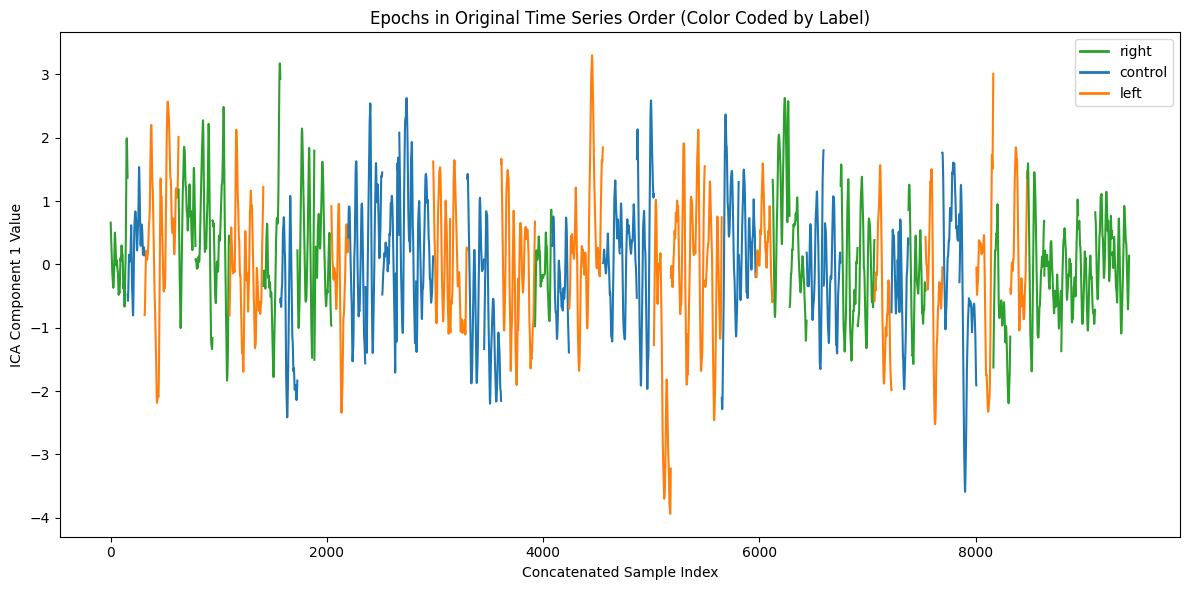

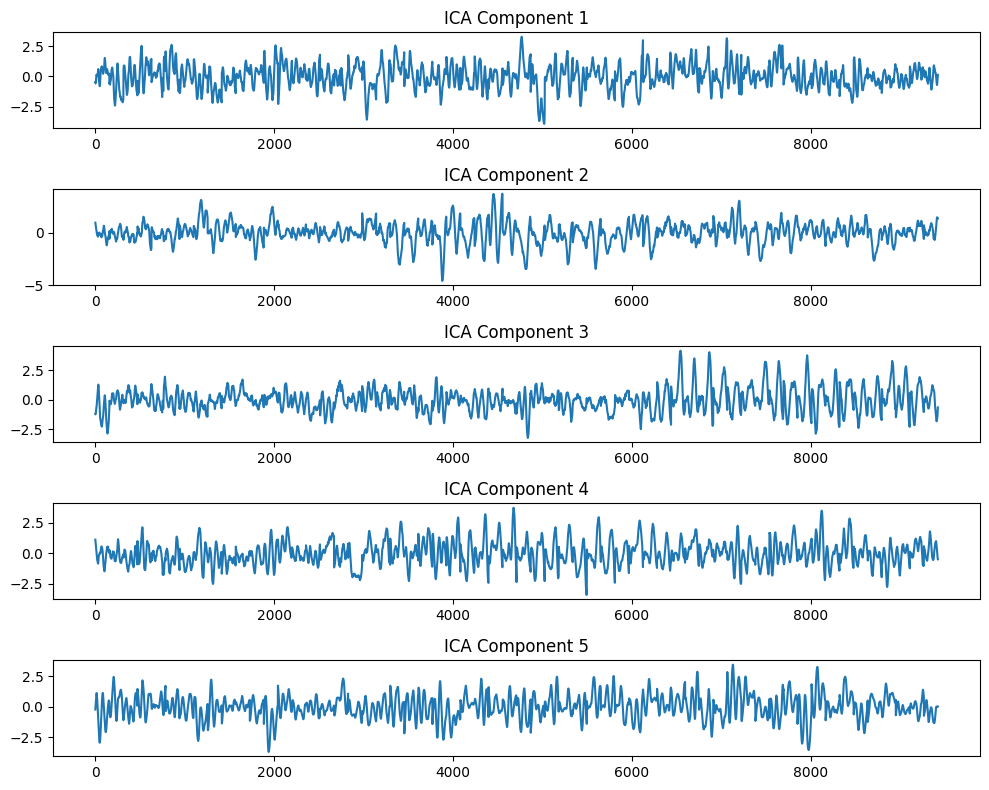

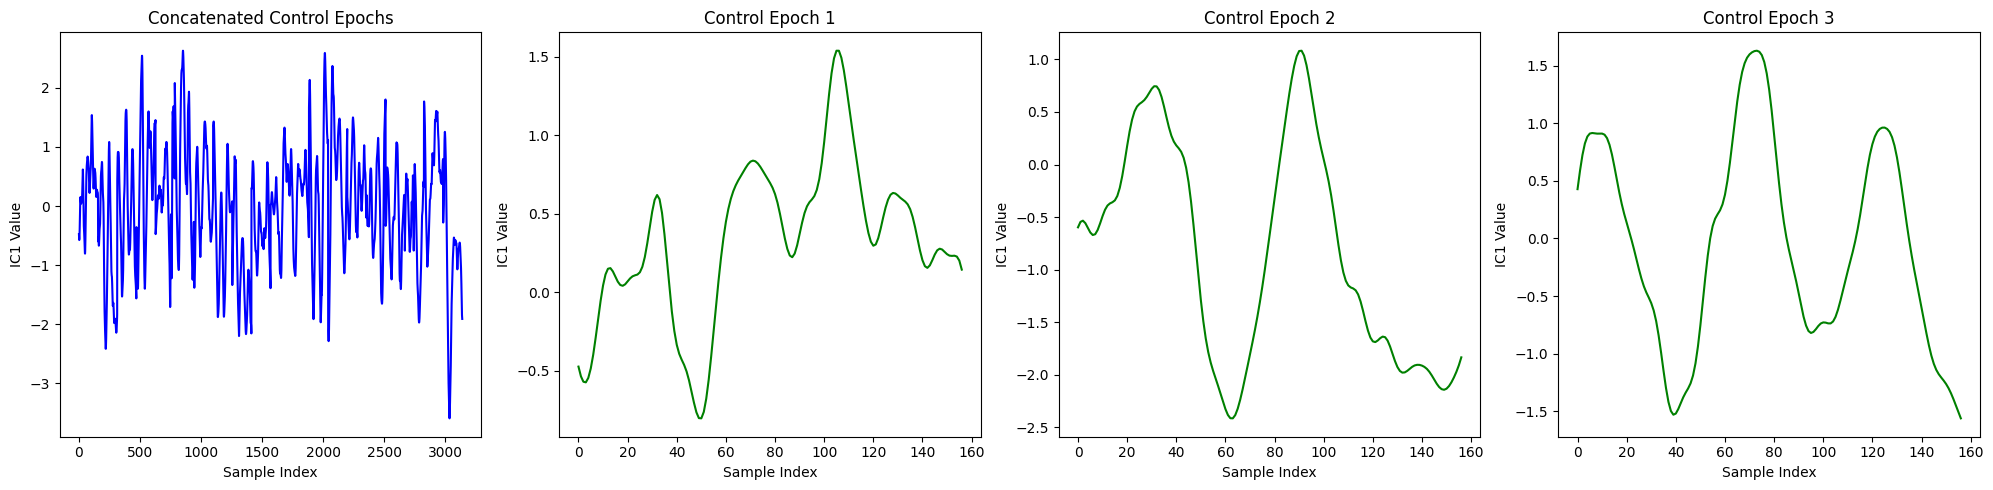

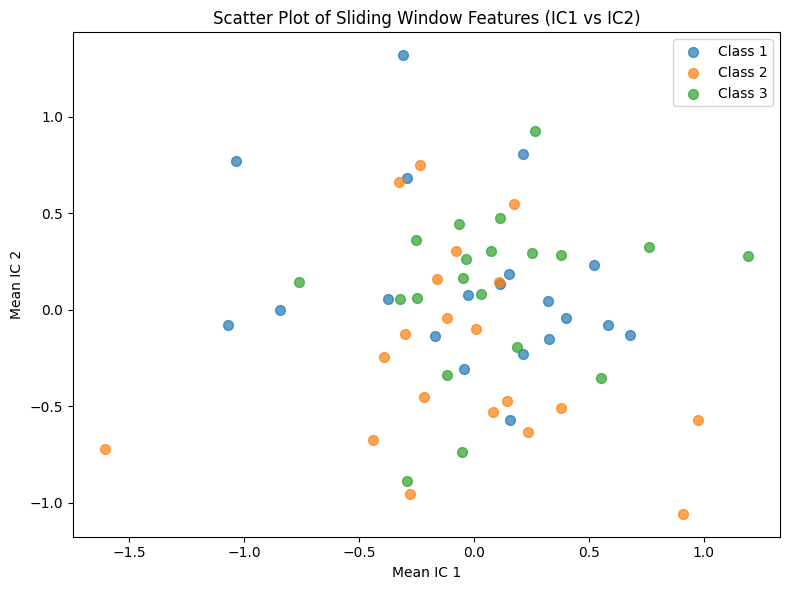

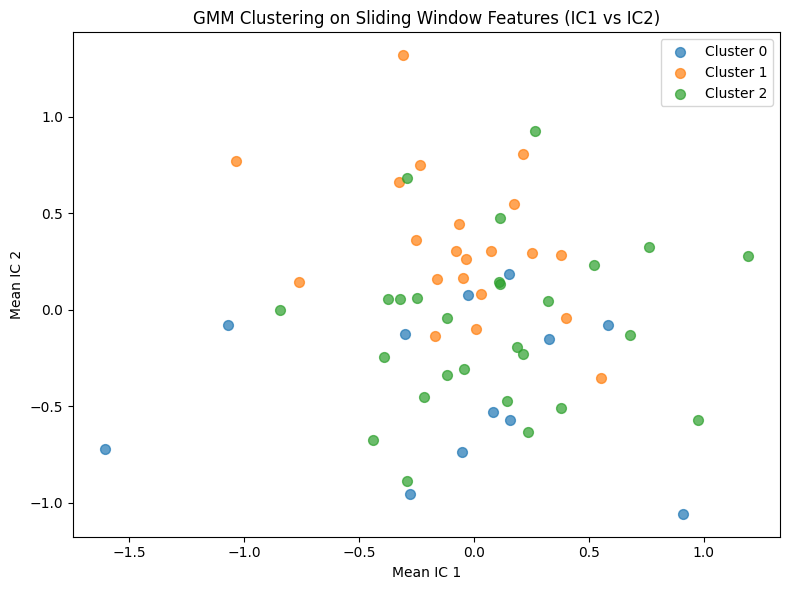

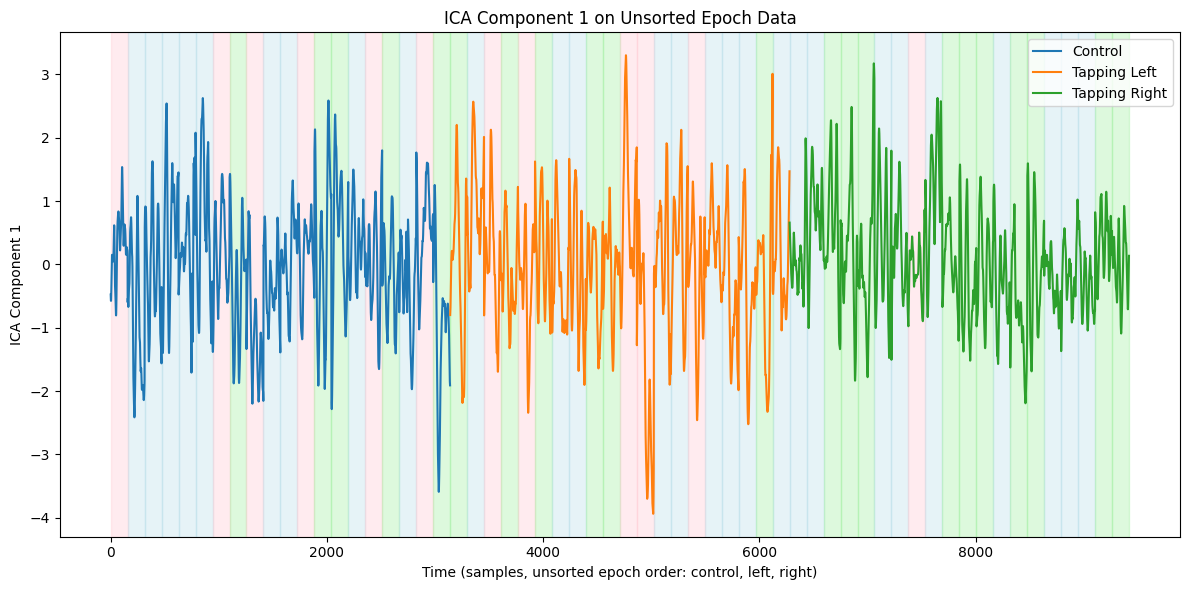

In [ ]:
import os
import numpy as np
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from preprocessing_mne import get_raw_subject_data, get_raw_control_subject_data
from ICA_plotting import *
from sklearn.metrics import silhouette_score
import random
import matplotlib.pyplot as plt

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

def reshape_epochs_with_indices(epochs, n_epochs_to_include):
    """
    Reshape epochs data to a 2D array and create an index array that indicates the original epoch for each sample.
    Using the minimum number of samples from the conditions for uniformity for concatenation.

    Parameters:
        epochs: MNE epochs object containing the data.
        n_epochs_to_include: Number of epochs to include (using the minimum sample count for uniformity).

    Returns:
        tuple: (reshaped data, array of original epoch indices)
    """
    n_epochs_to_include = 20
    # epoch_data = epochs.get_data()[:n_epochs_to_include:2, :, :]
    epoch_data = epochs.get_data()[:n_epochs_to_include, :, :]
    n_epoch, n_channels, n_epoch_size = epoch_data.shape
    epoch_data_reshaped = epoch_data.swapaxes(1,2).reshape(n_epoch*n_epoch_size, n_channels)
    # epoch_data_reshaped = epoch_data.reshape(n_channels, n_epoch * n_epoch_size).T
    orig_indices = np.repeat(epochs.selection[:n_epochs_to_include], n_epoch_size)
    return epoch_data_reshaped, orig_indices

def load_data(subject=3, control_only=True):
    """
    Load data from MNE, reshape epochs, and concatenate data from control, left, and right conditions.
    We assume that the clinical trials can split the data up into control and potential activation

    Parameters:
        subject: Subject ID to load data for.

    Returns:
        tuple: (X, orig_indices, y, control_data, left_data, right_data, numb_samples)
            - X: concatenated continuous data.
            - orig_indices: epoch indices for each sample.
            - y: labels for each sample.
            - control_data, left_data, right_data: individual condition data.
            - numb_samples: length of the first epoch sample (number of time points).
    """

    if not control_only:
        epochs = get_raw_subject_data(subject=subject, tmin=-5, tmax=15)
        # epochs["Control"].plot_image(
        #     combine="mean",
        #     vmin=-30,
        #     vmax=30,
        #     ts_args=dict(ylim=dict(hbo=[-15, 15], hbr=[-15, 15])),
        # )
        control = epochs['Control']
        left = epochs['Tapping_Left']
        right = epochs['Tapping_Right']

        control.pick_types(fnirs='hbo')
        left.pick_types(fnirs='hbo')
        right.pick_types(fnirs='hbo')
        
        min_bound = np.min([x.get_data().shape[0] for x in [control, left, right]])
        
        control_only_data, ctrl_idx = reshape_epochs_with_indices(control, min_bound)
        left_data, left_idx = reshape_epochs_with_indices(left, min_bound)
        right_data, right_idx = reshape_epochs_with_indices(right, min_bound)
        
        # Concatenating data. Doesn't impact ICA
        X = np.concatenate([control_only_data, left_data, right_data], axis=0)
        orig_indices = np.concatenate([ctrl_idx, left_idx, right_idx])
        y = np.concatenate([np.full(control_only_data.shape[0], 1),
                            np.full(left_data.shape[0], 2),
                            np.full(right_data.shape[0], 3)])
        # Get number of samples from the first epoch of the control condition.
        numb_samples = control.get_data()[0].shape[1]
        return X, orig_indices, y, control_only_data, left_data, right_data, numb_samples
    else:
        control = get_raw_control_subject_data(subject=subject)
        control_only_data, ctrl_idx = reshape_epochs_with_indices(control, control.selection.shape[0])
        y = np.full(control_only_data.shape[0], 1)  # All control data labeled as 1
        # Get number of samples from the first epoch of the control condition.
        numb_samples = control.get_data()[0].shape[1]
        return control_only_data, ctrl_idx, y, control_only_data, None, None, numb_samples


def run_ica(X, n_components=5, standardized=False):
    """
    Run Independent Component Analysis (ICA) to unmix the data.

    Parameters:
        X: Input data array.
        n_components: Number of independent components to retrieve.

    Returns:
        X_ica: Transformed data with independent components.
    """
    if standardized:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X = X_scaled
    ica = FastICA(n_components=n_components, max_iter=1000, tol=0.0001, random_state=42)
    X_ica = ica.fit_transform(X)
    return X_ica

def compute_sliding_windows(X_ica, y, window_size, step_size):
    """
    Compute features by calculating the mean over sliding windows for each class.
    Windows from different classes don't overlap.

    Parameters:
        X_ica: Data after ICA transformation.
        y: Labels for each sample.
        window_size: Number of samples in each sliding window.
        step_size: Step size between sliding windows.

    Returns:
        tuple: (features, labels) for each sliding window.
    """
    features_list, labels_list = [], []
    for cl in np.unique(y):
        class_mask = (y == cl)
        class_data = X_ica[class_mask, :]
        n_samples_class = class_data.shape[0]
        for start in range(0, n_samples_class - window_size + 1, step_size):
            window = class_data[start:start+window_size, :]
            avg_feature = np.mean(window, axis=0)
            features_list.append(avg_feature)
            labels_list.append(cl)
    return np.array(features_list), np.array(labels_list)

def run_gmm(features, n_components=3):
    """
    Cluster sliding window features using Gaussian Mixture Model.

    Parameters:
        features: Feature matrix extracted from sliding windows.
        n_components: Number of GMM components (clusters).

    Returns:
        tuple: (gmm model, cluster labels for each feature)
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features)
    cluster_labels = gmm.predict(features)
    return gmm, cluster_labels

def plot_epochs_in_original_order(X_ica, orig_indices, y, component=0):
    """
    Plot the epochs concatenated in the original time series order on a single plot.
    Each epoch is plotted sequentially, color coded by its original label:
        1: control, 2: left, 3: right.
    The legend shows one entry per label.
    """
    # Define colors and label names for each original label
    colors = {1: "C0", 2: "C1", 3: "C2"}
    label_names = {1: "control", 2: "left", 3: "right"}

    unique_epochs = np.unique(orig_indices)
    unique_epochs.sort()  # ensure original order

    plt.figure(figsize=(12, 6))
    offset = 0
    # Dictionary to hold one legend handle per label.
    legend_handles = {}
    for epoch in unique_epochs:
        mask = orig_indices == epoch
        epoch_data = X_ica[mask, component]
        # Use the first sample's label for this epoch.
        epoch_label = y[mask][0]
        epoch_color = colors.get(epoch_label, "black")
        n_samples = len(epoch_data)
        x_vals = np.arange(offset, offset + n_samples)
        plt.plot(x_vals, epoch_data, color=epoch_color)
        # Create a legend handle if it doesn't exist yet.
        if epoch_label not in legend_handles:
            legend_handles[epoch_label] = plt.Line2D(
                [0], [0], color=epoch_color, lw=2, label=label_names.get(epoch_label, "unknown")
            )
        offset += n_samples

    plt.xlabel("Concatenated Sample Index")
    plt.ylabel(f"ICA Component {component + 1} Value")
    plt.title("Epochs in Original Time Series Order (Color Coded by Label)")
    plt.legend(handles=list(legend_handles.values()))
    plt.tight_layout()
    plt.show()

def plot_first3_and_concatenated_control_epochs(X_ica, orig_indices, y, control_data, window_size, control_only):
    """
    Plots the concatenated control epochs alongside the first 3 individual control epochs.
  
    Parameters:
        X_ica: Array of ICA components.
        orig_indices: Array of original epoch indices for each sample.
        y: Labels corresponding to each sample.
        control_data: Original control data (used to determine concatenation length).
        window_size: Window size used for plotting sliding windows.
        control_only: Boolean flag (if True then data contains only control epochs).
    """
    # Determine concatenated control signal.
    if not control_only:
        concat_length = control_data.shape[0]
        concatenated_control = X_ica[:concat_length, 0]
    else:
        concatenated_control = X_ica[:, 0]

    # Extract the first 3 control epochs (sorted order).
    control_epochs = []
    unique_epochs = np.unique(orig_indices)
    unique_epochs.sort()
    for epoch in unique_epochs:
        mask = orig_indices == epoch
        if y[mask][0] == 1:
            control_epochs.append(epoch)
            if len(control_epochs) == 3:
                break

    # Create a figure with 4 subplots: one for the concatenated and three for individual epochs.
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot concatenated control epochs.
    axs[0].plot(concatenated_control, color="blue")
    axs[0].set_title("Concatenated Control Epochs")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("IC1 Value")

    # Plot each of the first 3 individual control epochs.
    for i, epoch in enumerate(control_epochs):
        mask = orig_indices == epoch
        epoch_data = X_ica[mask, 0]
        axs[i+1].plot(epoch_data, color="green")
        axs[i+1].set_title(f"Control Epoch {i+1}")
        axs[i+1].set_xlabel("Sample Index")
        axs[i+1].set_ylabel("IC1 Value")

    plt.tight_layout()
    plt.show()


# ------------------ Main Flow ------------------
if __name__ == '__main__':
    window_size = 300
    step_size = 50
    control_only = False

    # Load data and concatenate epochs from control, left, and right conditions
    X, orig_indices, y, control_data, left_data, right_data, num_samples = load_data(subject=3, control_only=control_only)
    window_size = step_size = num_samples

    # Run ICA to obtain independent components
    X_ica = run_ica(X, n_components=5, standardized=False)
    
    plot_epochs_in_original_order(X_ica, orig_indices, y)    
    # Plot the independent components
    plot_ica_components(X_ica)

    plot_first3_and_concatenated_control_epochs(X_ica, orig_indices, y, control_data, window_size, control_only)

    # for _ in range(3):
    #     # Plot a single control epoch with sliding windows.
    #     unique_epochs = np.unique(orig_indices)
    #     np.random.shuffle(unique_epochs)
    #     control_epoch_data = None
    #     for epoch_id in unique_epochs:
    #         ep_mask = orig_indices == epoch_id
    #         if y[ep_mask][0] == 1:
    #             control_epoch_data = X_ica[ep_mask, 0]
    #             break
    #     if control_epoch_data is not None:
    #         plot_ica_epoch(control_epoch_data, window_size)

    
    # Compute sliding window features
    features, sw_labels = compute_sliding_windows(X_ica, y, window_size, step_size)
    
    # Cluster sliding window features
    gmm, cluster_labels = run_gmm(features, n_components=3)
    
    # Plot sliding window features and their GMM clusters
    plot_scatter_features(features, sw_labels)
    plot_gmm_clusters(features, cluster_labels)
    
    # Plot the concatenated control IC1 time series
    if not control_only:
        # Calculate unsorted boundaries: order: control, left, right
        boundary0 = 0
        boundary1 = control_data.shape[0]
        boundary2 = boundary1 + left_data.shape[0]
        boundary3 = boundary2 + right_data.shape[0]
        boundaries = [boundary0, boundary1, boundary2, boundary3]
        X_ica_unsorted = X_ica  # Preserved unsorted order
    
        # Plot unsorted time series with sliding window bands color-coded by GMM clusters
        block_colors = {1: "C0", 2: "C1", 3: "C2"}
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        plot_unsorted_timeseries_with_clusters(X_ica_unsorted, boundaries, block_colors,
                                               window_size, step_size, sw_labels, cluster_labels, cluster_colors, ic=0, show_mean=False)
        # sil_score = silhouette_score(features, cluster_labels)
        # print(f"Silhouette Score: {sil_score:.3f}")
    else:
        # For control-only data, plot the control timeseries in black with cluster highlights.
        # X_ica contains only control epochs so no mask is needed.
        cluster_colors = {0: "pink", 1: "lightgreen", 2: "lightblue"}
        control_ic1 = X_ica[:, 0]
        plot_control_timeseries_with_clusters(control_ic1, window_size, step_size, cluster_labels, cluster_colors)
        # sil_score = silhouette_score(features, cluster_labels)
        # print(f"Silhouette Score: {sil_score:.3f}")
    
    

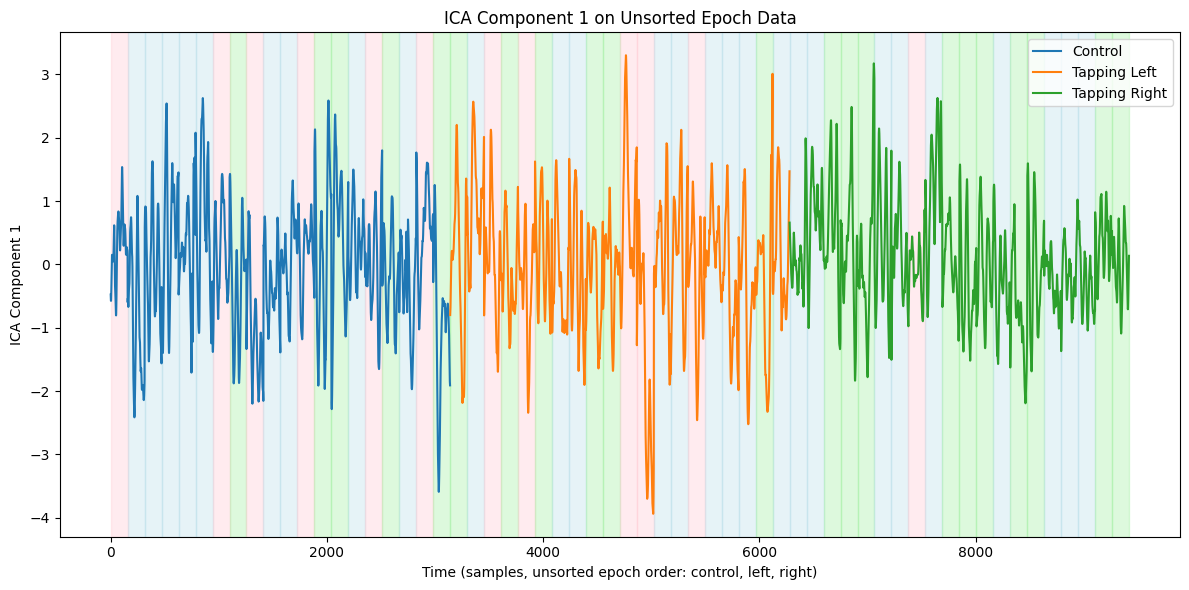